# Trump Tweets

This the data behind the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/).

In [2]:
# The usual suspects ...
import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time_series as ts

# And their accomplices ...
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint
from warnings import filterwarnings

# Settings
filterwarnings('ignore')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Getting the data
df = pd.read_csv('data/realDonaldTrump_poll_tweets.csv')

In [4]:
# Size
df.shape

(448, 3)

In [5]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


#### Preprocessing

In [6]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

In [7]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, '')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0           Its just a 2point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17Point Positive Swing ...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

In [9]:
# Emoticons and emojis
# HappyEmoticons
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                       ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                       '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                       'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                       '<3'])

# Sad Emoticons
emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                     ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                     ':c', ':{', '>:\\', ';('])

# Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# Combine
emoticons = emoticons_happy.union(emoticons_sad)

In [10]:
# Text corpus
document = [i for i in df['text']]

# Removing common words and tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
                   'amp', 'kkk', 'hahaha', 'haha', 'ha'])
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

# Removing empty tokens
texts = [text for text in texts if len(text) > 1]

# Removing emojis
texts = [[token for token in text if token not in emoticons] for text in texts]

# Printing the top 10
#pprint(texts[:10])

#### Transformation: Document dictionary

In [11]:
# Create dictionary of document
bag = corpora.Dictionary(texts)
bag.save('models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('models/trump.mm', corpus)

We have assigned a unique integer id to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts and relevant statistics
   
Our corpus is a 448 x 661 matrix.

***

#### Transformation: _tf-idf_

#### Step 1:

In [12]:
# Initialization
tfidf = models.TfidfModel(corpus)

We have initialized (trained) a transaformation model. Different transformation may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features. This is in comparison to ___Latent Semantic Analysis___ & ___Latent Dirichlet Allocation___ which are more involved and take more time.

**A note on transaformations**:
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

#### Step 2:
From now on, ___tf-idf___ is treated as a read-only object that can be used to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights).

In [13]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

We have transformed our corpus (the one we used for training) into a weighted vector. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___.

#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent 10-D space (... num_topics = 10).

In [14]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lsi = lsi[corpus_tfidf]

In [15]:
lsi.print_topics()

[(0,
  '-0.587*"thank" + -0.417*"new" + -0.410*"great" + -0.209*"poll" + -0.156*"america" + -0.148*"numbers" + -0.132*"iowa" + -0.116*"reuters" + -0.106*"trump" + -0.103*"support"'),
 (1,
  '-0.444*"thank" + 0.338*"trump" + 0.216*"donald" + 0.201*"lead" + 0.196*"carson" + 0.191*"leads" + 0.188*"rubio" + 0.172*"national" + 0.171*"cruz" + 0.146*"debate"'),
 (2,
  '0.389*"great" + -0.273*"thank" + 0.232*"big" + 0.228*"numbers" + 0.201*"america" + -0.201*"carson" + 0.187*"make" + 0.178*"debate" + -0.178*"rubio" + 0.160*"good"'),
 (3,
  '0.426*"great" + -0.384*"national" + 0.323*"leads" + -0.263*"iowa" + -0.213*"lead" + 0.194*"rubio" + -0.169*"released" + 0.161*"trump" + 0.153*"carson" + -0.149*"debate"'),
 (4,
  '-0.415*"debate" + 0.327*"national" + -0.254*"thank" + -0.252*"said" + 0.204*"new" + 0.184*"leads" + 0.164*"america" + -0.143*"carson" + -0.139*"every" + -0.136*"winning"')]

#### Topics

According to ___LSI___:
<br>
**Topic 1**
> References poll numbers, Iowa, Reuters and Trump.

**Topic 2**
> References Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.

**Topic 3**
> References debate, Carson, and Rubio hinting at what these individuals may have said in the debate.

**Topic 4**
> References great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.

**Topic 5**
> References similar words as topic 4.

In [16]:
# Model persistence: save(), load()
lsi.save('models/trump.lsi')
lsi = models.LsiModel.load('models/trump.lsi')

***
### Similarity

#### Step 1:

In [17]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus])

# Index persistence
index.save('models/trump.index')
index = similarities.MatrixSimilarity.load('models/trump.index')

#### Step 2:

In [18]:
def query_similarity(doc, index=index):
    
    # Performing queries
    vec_bow = bag.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec_lsi = lsi[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec_lsi]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(10):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

In [19]:
query_similarity(doc='Hillary Clinton', index=index)

Tweet Rank #1:	Weight: 0.9818666577339172
Raw text: Hillary Clinton is not a change agent just the same old status quo She is spending a fortune I am spending very little Close in polls

Tweet Rank #2:	Weight: 0.9747333526611328
Raw text: The refused to use their just in poll numbers where I have a massive lead but instead used numbers where my lead is smaller

Tweet Rank #3:	Weight: 0.9722009897232056
Raw text: Sickening attempt I hope jumps another 10 points

Tweet Rank #4:	Weight: 0.9700294733047485
Raw text: Ted Cruz didnt win Iowa he stole it That is why all of the polls were so wrong and why he got far more votes than anticipated Bad

Tweet Rank #5:	Weight: 0.9629718065261841
Raw text: CNBC poll Trump won

Tweet Rank #6:	Weight: 0.9616483449935913
Raw text: Watch my interview on Face The Nation now and also the new CBS POLLS which if good for me the media wont report

Tweet Rank #7:	Weight: 0.9415106773376465
Raw text: Nevada Poll Donald Trump 33 Ted Cruz 20 Marco Rubio 11 via Gr

When we make a query for "Hillary Clinton" to retrieve the respective top tweets associated with her name, we find that the leading tweet with the greatest weight is a strong criticism of Hillary Clinton and her campaign spending. The remaining nine tweets are associated with the polls, darted with references to Donald Trump criticizing poll results not in his favor, him leading against the opposition as well as pitting himself likely to win.

In [20]:
# Performing queries
query_similarity(doc="Ben Carson")

Tweet Rank #1:	Weight: 0.9968047142028809
Raw text: All seven online polls including Drudge and Time with thousands of respondents said I won the debate said I was so so

Tweet Rank #2:	Weight: 0.9925204515457153
Raw text: Morning Consult poll Trump Leads

Tweet Rank #3:	Weight: 0.9866147637367249
Raw text: New CNNORC poll w 24 favorability rating on the rise while Jebs declines 60 among women

Tweet Rank #4:	Weight: 0.976577639579773
Raw text: Rasmussen now beats 3836 nationally

Tweet Rank #5:	Weight: 0.9753714799880981
Raw text: WSJNBC Poll Donald Trump Widens His Lead in Republican Presidential Race

Tweet Rank #6:	Weight: 0.9693527221679688
Raw text: RT New poll finds lean Republicans think most likely to be GOP nominee and has best cha…

Tweet Rank #7:	Weight: 0.967344343662262
Raw text: GREAT Video Which of these 4 Polls is Suspect Kudos to

Tweet Rank #8:	Weight: 0.9665062427520752
Raw text: Good morning America Thank you for all of your support in the latest Drudge poll

Tweet

#### Transformation: LDA

In [21]:
# LDA Transformation
lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lda = lda[corpus_tfidf]

In [22]:
lda.print_topics()

[(0,
  '0.020*"new" + 0.020*"thank" + 0.012*"poll" + 0.011*"iowa" + 0.010*"great" + 0.010*"reuters" + 0.009*"trump" + 0.008*"hampshire" + 0.008*"america" + 0.008*"wow"'),
 (1,
  '0.012*"trump" + 0.009*"win" + 0.009*"cruz" + 0.008*"poll" + 0.008*"national" + 0.008*"donald" + 0.008*"new" + 0.008*"hillary" + 0.007*"great" + 0.007*"even"'),
 (2,
  '0.017*"thank" + 0.011*"trump" + 0.011*"new" + 0.011*"great" + 0.010*"carson" + 0.009*"poll" + 0.008*"national" + 0.008*"place" + 0.008*"leading" + 0.008*"big"'),
 (3,
  '0.019*"great" + 0.017*"new" + 0.012*"debate" + 0.010*"trump" + 0.010*"thank" + 0.009*"good" + 0.009*"america" + 0.009*"poll" + 0.009*"big" + 0.008*"via"'),
 (4,
  '0.013*"numbers" + 0.012*"thank" + 0.010*"poll" + 0.010*"trump" + 0.009*"new" + 0.009*"lead" + 0.009*"great" + 0.008*"10" + 0.008*"news" + 0.008*"iowa"')]

In [23]:
# Visualizing LDA topic models
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.053215 -0.011526       1        1  21.678234
4     -0.026489 -0.023381       2        1  21.555325
3      0.049440 -0.045491       3        1  21.145679
0      0.022615  0.026819       4        1  20.935574
2      0.007650  0.053579       5        1  14.685181, topic_info=    Category       Freq        Term      Total  loglift  logprob
296  Default   8.000000       place   8.000000  30.0000  30.0000
11   Default  45.000000       thank  45.000000  29.0000  29.0000
40   Default  14.000000        good  14.000000  28.0000  28.0000
147  Default  12.000000     winning  12.000000  27.0000  27.0000
408  Default   4.000000   reporting   4.000000  26.0000  26.0000
38   Default   5.000000   democrats   5.000000  25.0000  25.0000
299  Default   7.000000   respected   7.000000  24.0000  24.0000
102  Default  16.000000     reuters  16.000000  23.0000  23.0000
111  Default  10.000000        came  10.000000  22.0000  22.0000
283  Default   7.000000    received   7.000000  21.0000  21.0000
248  Default   8.000000        post   8.000000  20.0000  20.0000
211  Default   7.000000      nevada   7.000000  19.0000  19.0000
25   Default  18.000000     america  18.000000  18.0000  18.0000
19   Default  23.000000     numbers  23.000000  17.0000  17.0000
0    Default   6.000000          36   6.000000  16.0000  16.0000
137  Default  19.000000      carson  19.000000  15.0000  15.0000
10   Default  48.000000         new  48.000000  14.0000  14.0000
486  Default   8.000000  nomination   8.000000  13.0000  13.0000
86   Default  10.000000  republican  10.000000  12.0000  12.0000
171  Default  11.000000          10  11.000000  11.0000  11.0000
169  Default   8.000000           9   8.000000  10.0000  10.0000
81   Default  16.000000         wow  16.000000   9.0000   9.0000
361  Default  10.000000       first  10.000000   8.0000   8.0000
166  Default   8.000000          12   8.000000   7.0000   7.0000
179  Default   6.000000          28   6.000000   6.0000   6.0000
403  Default   7.000000      double   7.000000   5.0000   5.0000
29   Default   4.000000  nationwide   4.000000   4.0000   4.0000
139  Default  22.000000      debate  22.000000   3.0000   3.0000
92   Default   5.000000     believe   5.000000   2.0000   2.0000
16   Default  13.000000        even  13.000000   1.0000   1.0000
..       ...        ...         ...        ...      ...      ...
461   Topic5   1.610788   marketing   4.315121   0.9329  -5.8008
359   Topic5   2.603172          27   7.048396   0.9223  -5.3208
403   Topic5   2.747586      double   7.490607   0.9154  -5.2668
198   Topic5   1.765648       total   4.962473   0.8849  -5.7090
32    Topic5   2.160263        zero   6.151759   0.8718  -5.5073
1     Topic5   2.366676          38   6.769069   0.8675  -5.4161
460   Topic5   2.396862      gravis   6.887371   0.8628  -5.4034
137   Topic5   5.559322      carson  19.006451   0.6890  -4.5621
361   Topic5   3.205698       first  10.305234   0.7506  -5.1126
145   Topic5   2.745006      online   8.457962   0.7930  -5.2678
11    Topic5   9.071727       thank  45.916813   0.2967  -4.0724
114   Topic5   4.265748     leading  16.966312   0.5377  -4.8269
174   Topic5   2.357226    carolina   6.874359   0.8480  -5.4201
4     Topic5   5.700034       trump  37.419704   0.0366  -4.5371
197   Topic5   4.392021    national  22.898493   0.2670  -4.7978
7     Topic5   5.596920       great  40.752262  -0.0670  -4.5553
40    Topic5   3.395899        good  14.487919   0.4676  -5.0550
105   Topic5   4.068499         big  21.416082   0.2575  -4.8743
10    Topic5   5.600227         new  48.002174  -0.2301  -4.5547
8     Topic5   4.846518        poll  35.414242  -0.0705  -4.6993
195   Topic5   3.634588        lead  25.458328  -0.0282  -4.9871
245   Topic5   3.330399        iowa  23.569370  -0.0385  -5.0745
154   Topic5   2.911840        bush  14.905397   0.2854  -5.2088
2   

#### Dominant topics and percentage cotribution

In [24]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [25]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

In [26]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,2.0,0.8649,"thank, trump, new, great, carson, poll, nation...","[race, clinton, 38, trump, 36]"
1,1,3.0,0.8829,"great, new, debate, trump, thank, good, americ...","[poll, donald, trump, two, breitbart, great]"
2,2,0.0,0.8364,"new, thank, poll, iowa, great, reuters, trump,...","[great, new, poll, thank]"
3,3,1.0,0.9454,"trump, win, cruz, poll, national, donald, new,...","[great, poll, numbers, coming, people, dont, w..."
4,4,4.0,0.8631,"numbers, thank, poll, trump, new, lead, great,...","[another, new, poll, thank, support]"
5,5,0.0,0.8639,"new, thank, poll, iowa, great, reuters, trump,...","[great, new, poll, thank, america]"
6,6,2.0,0.8988,"thank, trump, new, great, carson, poll, nation...","[despite, spending, day, ads, nationwide, zero..."
7,7,0.0,0.8367,"new, thank, poll, iowa, great, reuters, trump,...","[great, poll, florida, thank]"
8,8,0.0,0.7963,"new, thank, poll, iowa, great, reuters, trump,...","[new, poll, thank]"
9,9,0.0,0.9092,"new, thank, poll, iowa, great, reuters, trump,...","[new, q, poll, going, win, make, america, great]"


#### Most representative sentence for each topic

In [27]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9521,"new, thank, poll, iowa, great, reuters, trump,...","[new, ppp, poll, released, iowa, 6, points, la..."
1,1.0,0.9610,"trump, win, cruz, poll, national, donald, new,...","[latest, umass, tracking, poll, nh, trump, 35,..."
2,2.0,0.9416,"thank, trump, new, great, carson, poll, nation...","[another, good, poll, result, great, state, sc..."
3,3.0,0.9520,"great, new, debate, trump, thank, good, americ...","[wow, new, reuters, poll, big, lead, want, mak..."
4,4.0,0.9542,"numbers, thank, poll, trump, new, lead, great,...","[new, poll, abc, post, trump, 32, carson, 22, ..."


#### Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

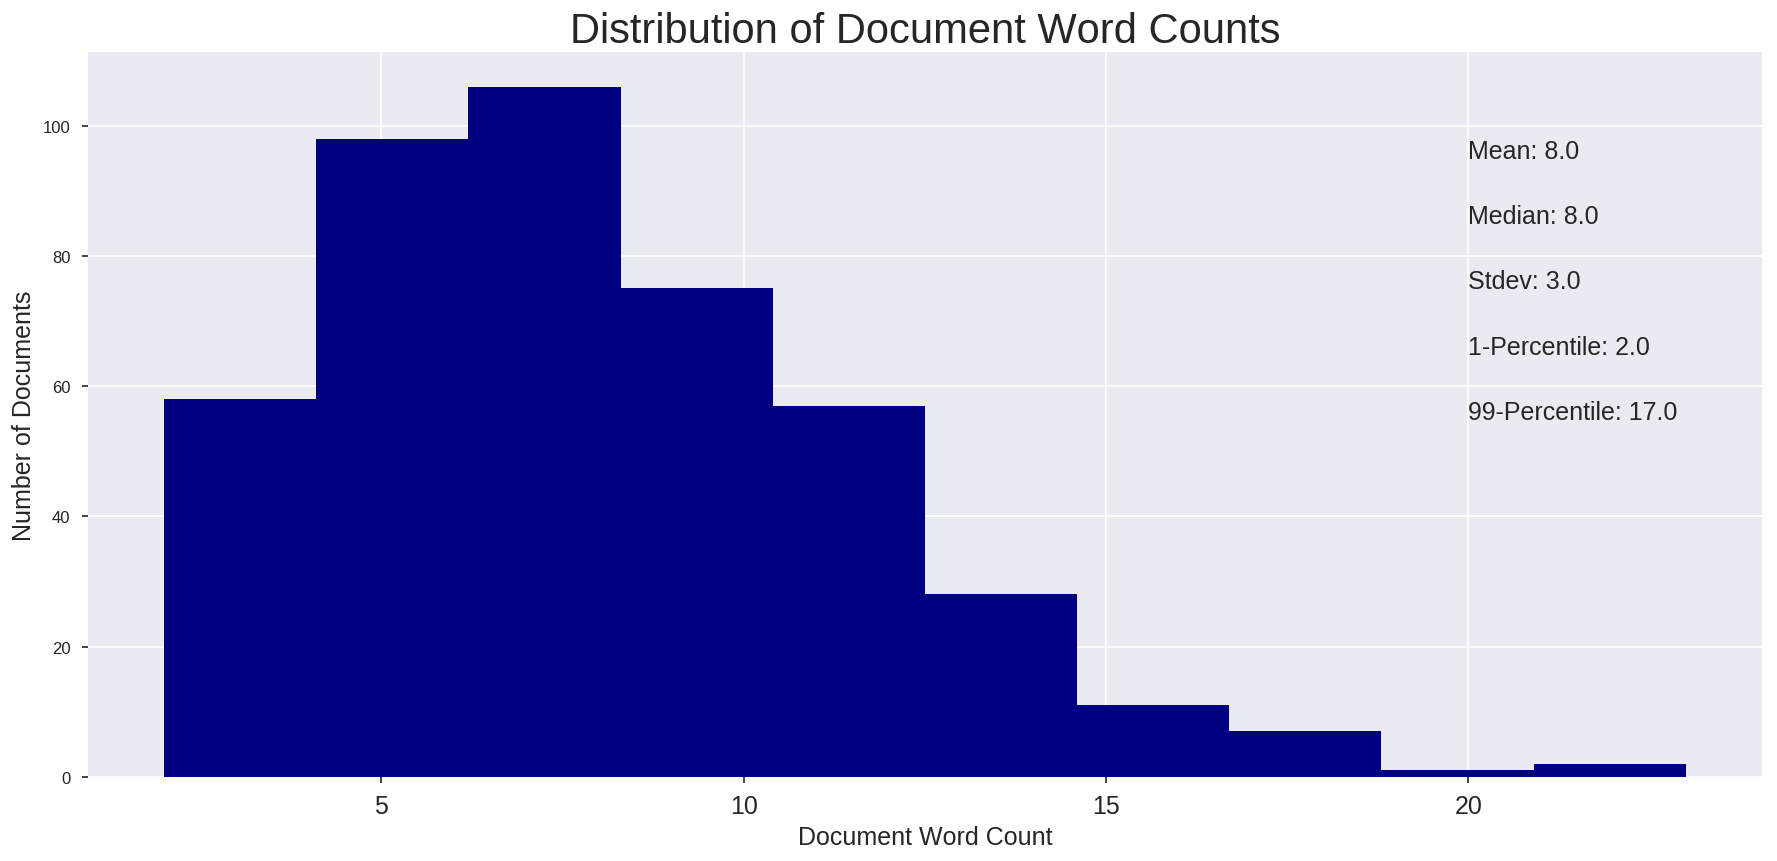

In [28]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=120)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=15)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=15)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=15)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=15)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=15)
plt.xticks(size=15)
plt.ylabel('Number of Documents', fontsize=15)
plt.xlabel('Document Word Count', fontsize=15)
plt.title('Distribution of Document Word Counts', fontsize=25)

#### Word counts of topic keywords

In [29]:
# Formatting
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = list()
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
data = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

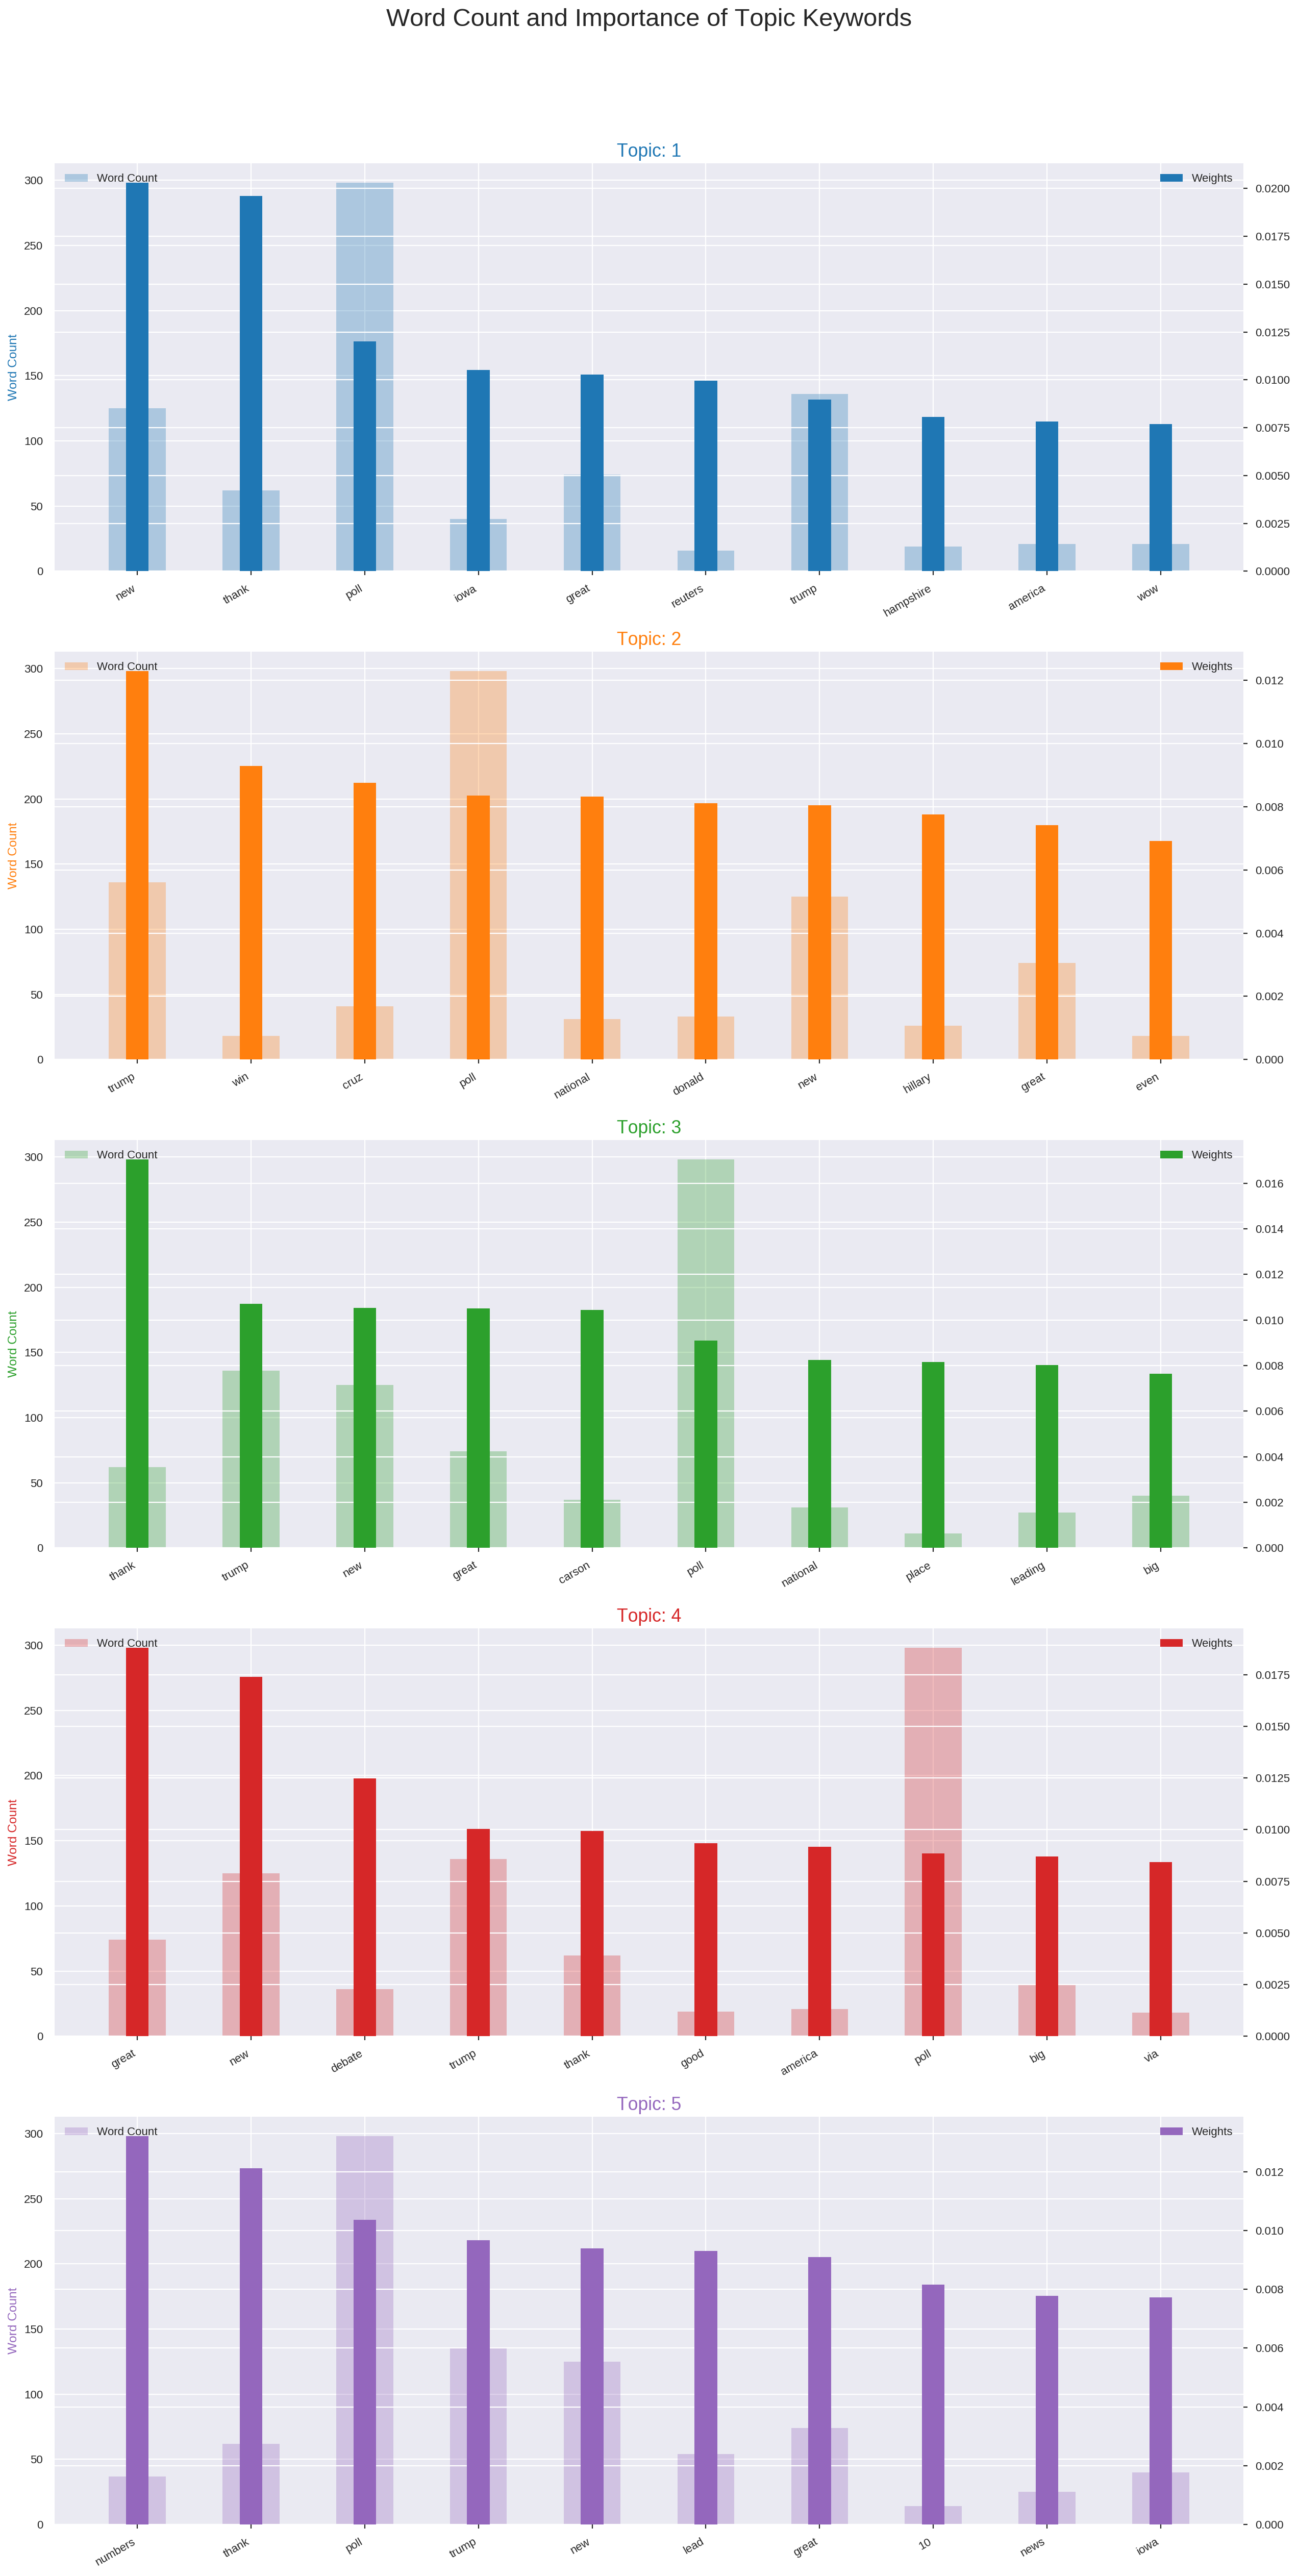

In [30]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 30), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

#### What are the most discussed topics in the tweets?

In [31]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [32]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [33]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [34]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

We will now make two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

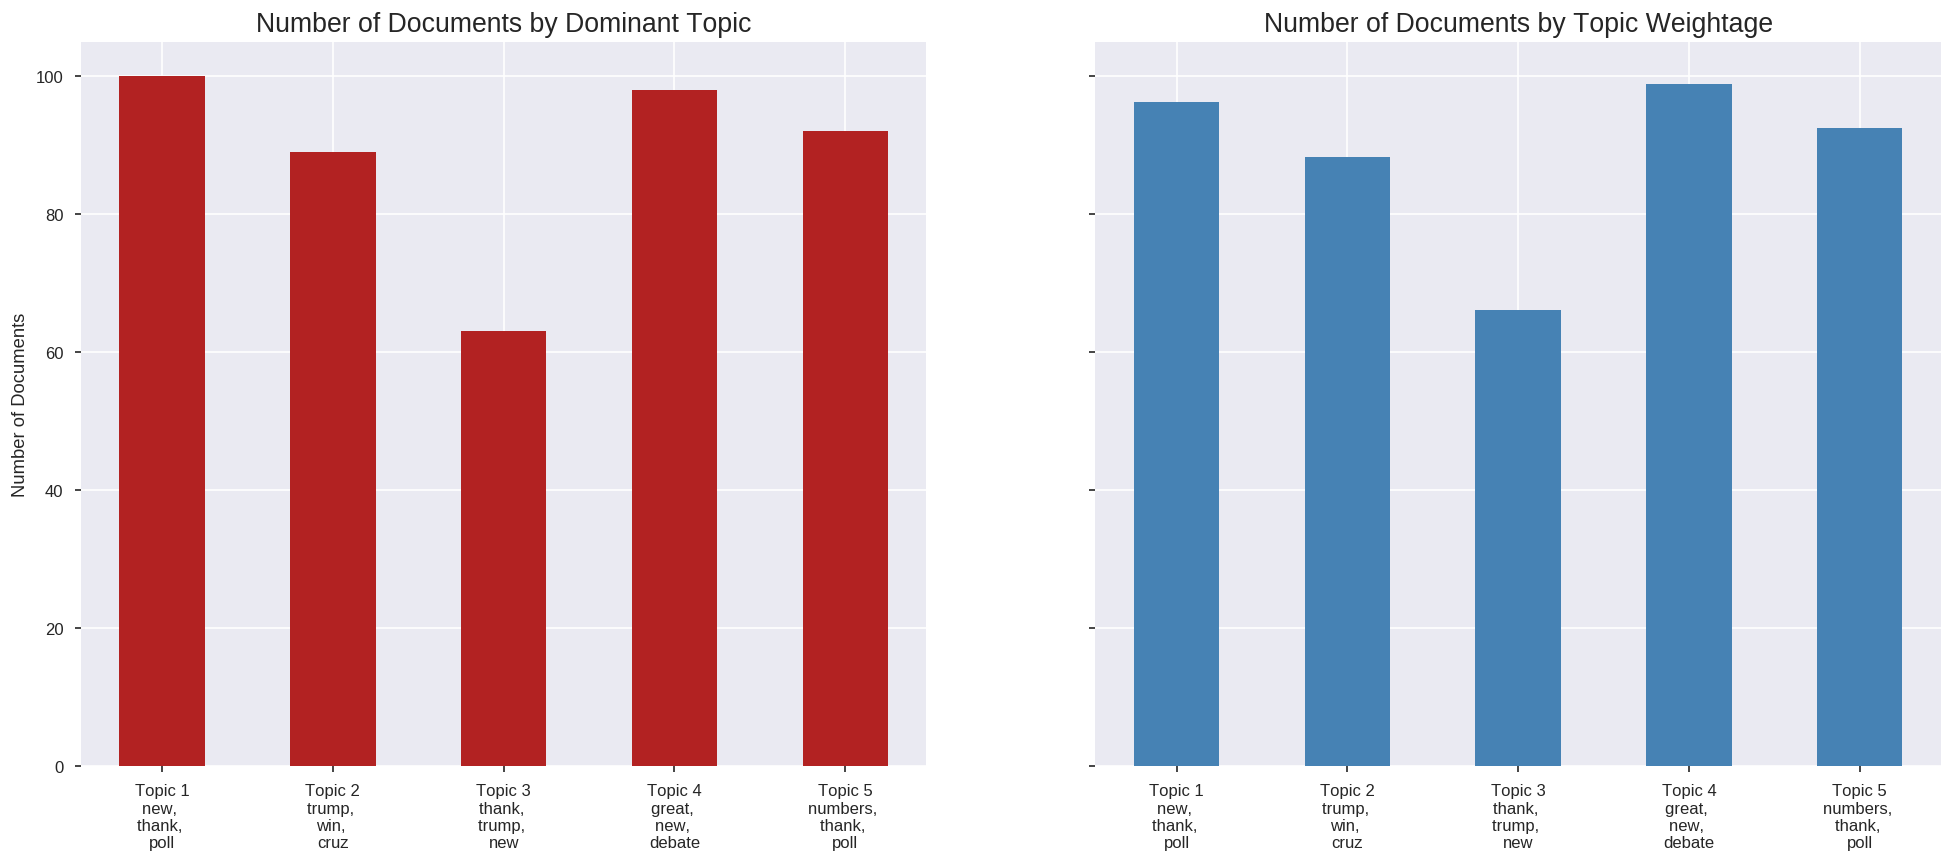

In [35]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

#### Polarity and subjectivity of sentiments

In [36]:
# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity, subjectivity = list(), list()
    for tweet in df[column]:
        blob = TextBlob(tweet)
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

polarity_and_subjectivity(df=df, column='text')

(None, None)

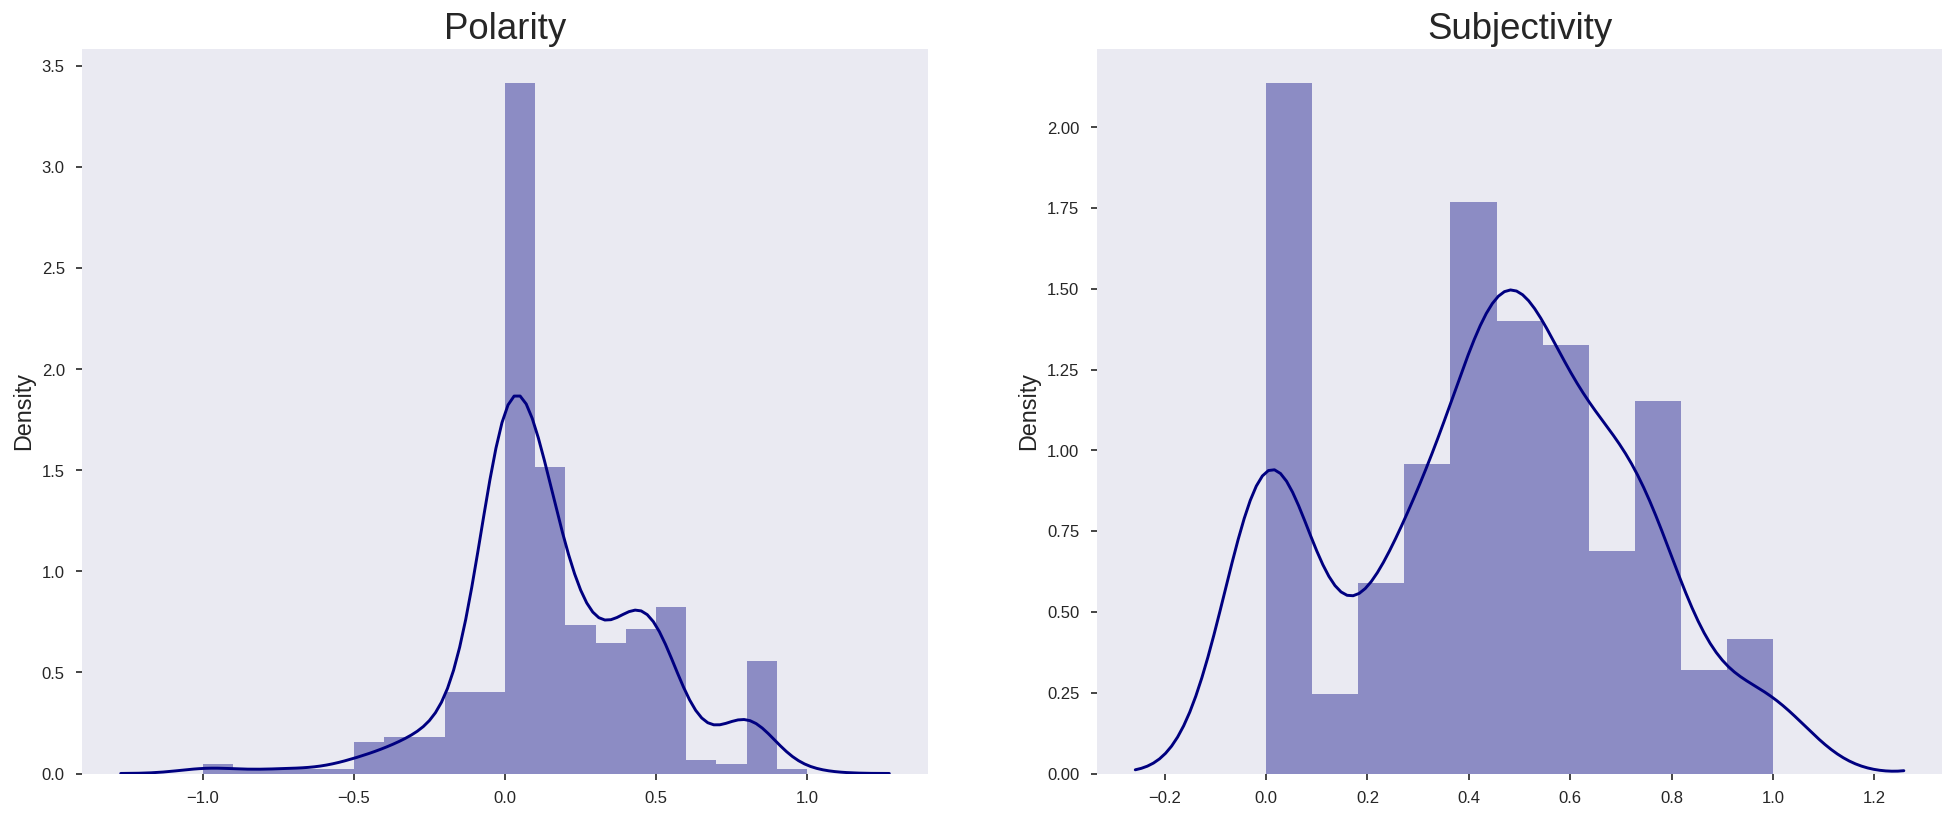

In [37]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120)
sns.distplot(df['polarity'], label='Polarity', ax=ax1, color='navy')
sns.distplot(df['subjectivity'], label='Subjectivity', ax=ax2, color='navy')
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14), ax2.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

In [38]:
df.profile_report()